In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
df = pd.read_csv('b.csv', encoding = 'ISO-8859-1', usecols=[ 'Review', 'Rating'])
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,unique \tgreat stay \twonderful time hotel mon...,5
4,great stay great stay \twent seahawk game awes...,5


In [7]:
import re

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",i)
    
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)
    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [8]:
df['Review1'] = df.Review.apply(remove_stopwords)
df['Clean_Review'] = df['Review1'].apply(normalize)

df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

In [9]:
df.head()

,Review,Rating,Review1,Clean_Review,posneg
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,0
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,0
3,unique \tgreat stay \twonderful time hotel mon...,5,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay \twent seahawk game awes...,5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,1


# TFIDF

In [10]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [12]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X = tfidf.fit_transform(df['Clean_Review'])
y = df['posneg'].values

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

## Random Forest

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7531105147596975
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2288
           1       0.78      0.61      0.69      1811

    accuracy                           0.75      4099
   macro avg       0.76      0.74      0.74      4099
weighted avg       0.76      0.75      0.75      4099



In [16]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

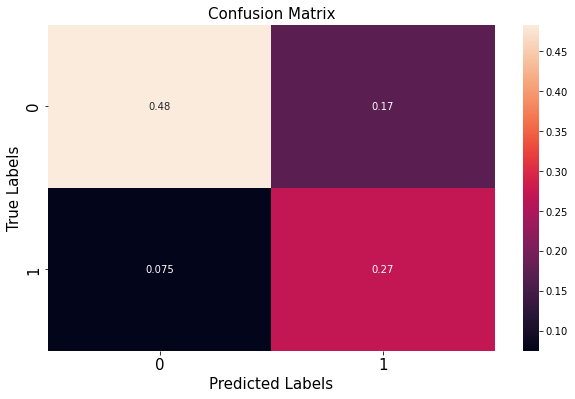

In [17]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7901927299341303
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2288
           1       0.76      0.77      0.76      1811

    accuracy                           0.79      4099
   macro avg       0.79      0.79      0.79      4099
weighted avg       0.79      0.79      0.79      4099



In [21]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

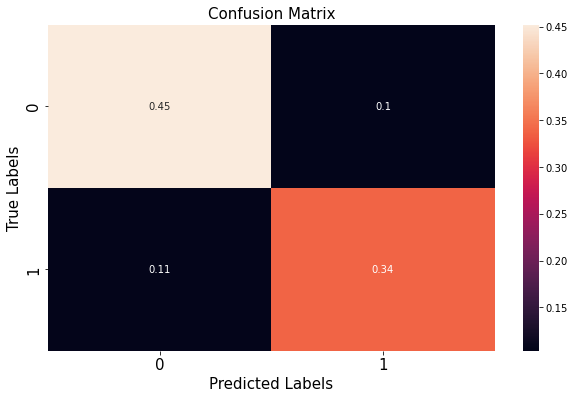

In [22]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

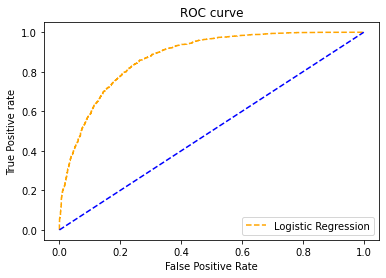

AUC score: 0.8749


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])


fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

print('AUC score:',round(auc_score1, 4))

# NN

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [26]:
X = df['Clean_Review']
y = df['posneg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [27]:
vocab_size = 100000
embedding_dim = 64
max_length = 128
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [28]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [29]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=METRICS)

In [30]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/10
154/154 [==============================] - 70s 444ms/step - loss: 0.6870 - accuracy: 0.5573 - val_loss: 0.6855 - val_accuracy: 0.5581
Epoch 2/10
154/154 [==============================] - 69s 446ms/step - loss: 0.6851 - accuracy: 0.5581 - val_loss: 0.6846 - val_accuracy: 0.5581
Epoch 3/10
154/154 [==============================] - 73s 472ms/step - loss: 0.6845 - accuracy: 0.5581 - val_loss: 0.6834 - val_accuracy: 0.5581
Epoch 4/10
154/154 [==============================] - 68s 440ms/step - loss: 0.6836 - accuracy: 0.5582 - val_loss: 0.6819 - val_accuracy: 0.5581
Epoch 5/10
154/154 [==============================] - 65s 426ms/step - loss: 0.6813 - accuracy: 0.5588 - val_loss: 0.6798 - val_accuracy: 0.5581
Epoch 6/10
154/154 [==============================] - 69s 452ms/step - loss: 0.6785 - accuracy: 0.5598 - val_loss: 0.6770 - val_accuracy: 0.5581
Epoch 7/10
154/154 [==============================] - 66s 431ms/step - loss: 0.6756 - accuracy: 0.5609 - val_loss: 0.6733 - val_ac

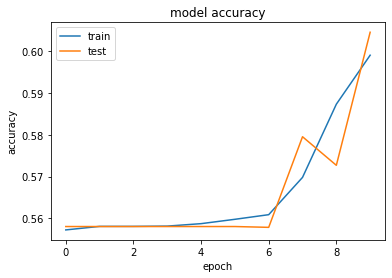

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

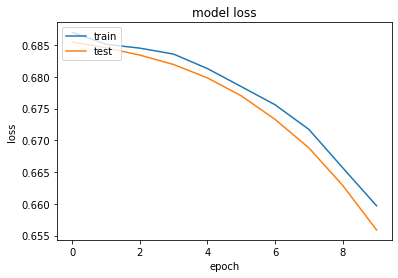

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)

161/161 [==============================] - 16s 97ms/step


In [34]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [35]:
print("---Test Set Results---")
print("Accuracy with NN: {}".format(accuracy_score(y_test, binary_predictions)))

---Test Set Results---
Accuracy with LSTM: 0.6045285965254733
              precision    recall  f1-score   support

           0       0.59      0.95      0.73      2859
           1       0.72      0.17      0.28      2264

    accuracy                           0.60      5123
   macro avg       0.66      0.56      0.50      5123
weighted avg       0.65      0.60      0.53      5123



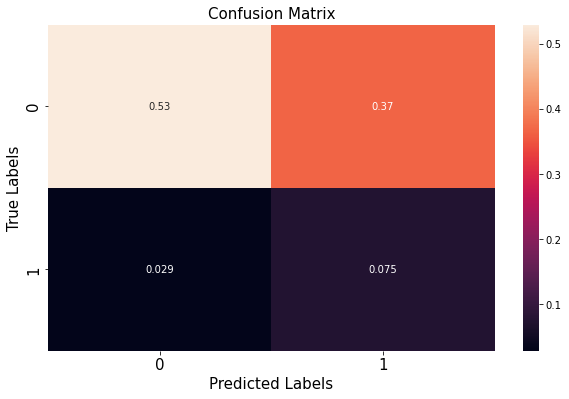

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

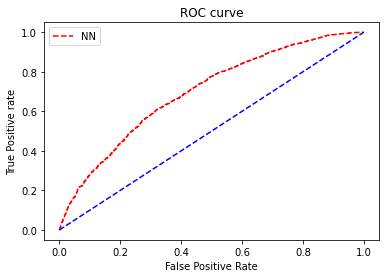

AUC score: 0.6965


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_score1 = auc(fpr_keras, tpr_keras)

# plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_keras, tpr_keras, linestyle='--',color='red', label='NN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))

## LSTM

In [38]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(outputs['sequence_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=METRICS)

In [40]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
462/462 [==============================] - 113s 234ms/step - loss: 0.6117 - accuracy: 0.6660 - val_loss: 0.5743 - val_accuracy: 0.7098
Epoch 2/10
462/462 [==============================] - 108s 235ms/step - loss: 0.5561 - accuracy: 0.7214 - val_loss: 0.5497 - val_accuracy: 0.7261
Epoch 3/10
462/462 [==============================] - 105s 228ms/step - loss: 0.5367 - accuracy: 0.7385 - val_loss: 0.5377 - val_accuracy: 0.7378
Epoch 4/10
462/462 [==============================] - 104s 226ms/step - loss: 0.5238 - accuracy: 0.7467 - val_loss: 0.5336 - val_accuracy: 0.7358
Epoch 5/10
462/462 [==============================] - 105s 227ms/step - loss: 0.5144 - accuracy: 0.7509 - val_loss: 0.5267 - val_accuracy: 0.7326
Epoch 6/10
462/462 [==============================] - 111s 241ms/step - loss: 0.5037 - accuracy: 0.7605 - val_loss: 0.5214 - val_accuracy: 0.7404
Epoch 7/10
462/462 [==============================] - 105s 227ms/step - loss: 0.4963 - accuracy: 0.7645 - val_loss: 0.5217 -

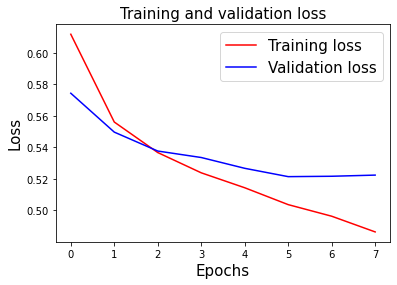

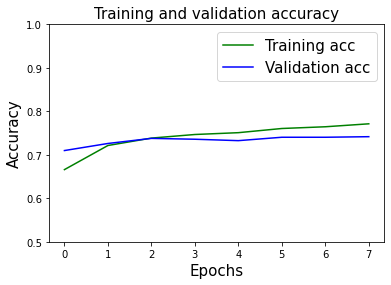

In [41]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [42]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

161/161 [==============================] - 23s 136ms/step


---Test Set Results---
Accuracy: 0.7431


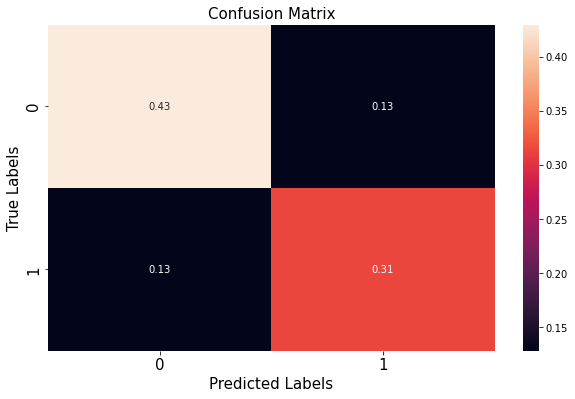

In [43]:
import seaborn as sns
print("---Test Set Results---")
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

print("Accuracy: {:.4f}".format(accuracy_score(y_test, binary_predictions)))

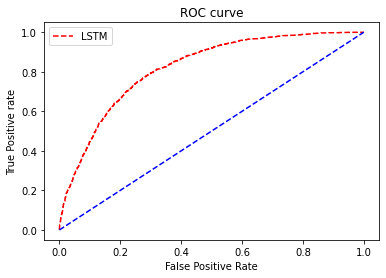

AUC score: 0.8186


In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred)

auc_score1 = auc(fpr_keras, tpr_keras)

# plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_keras, tpr_keras, linestyle='--',color='red', label='LSTM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))